# Eine Einführung in die Bildentfaltung

In der Mikroskopie werden Bilder aufgrund der Beschaffenheit des optischen Systems, des Mikroskops, häufig verzerrt. Eine biologische Struktur, die Photonen emittiert, wird visuell in einem Bild der Szene nicht zu 100% der Realität entsprechend erscheinen. Das Bild wird unscharf sein, gefaltet mit der Punktspreizfunktion (PSF) des optischen Aufbaus. Wenn wir die PSF kennen, ist es technisch möglich, diese Faltung bis zu einem gewissen Grad rückgängig zu machen.

In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage.data import cells3d
from skimage.filters import gaussian
from scipy.ndimage import convolve
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
from napari_simpleitk_image_processing import richardson_lucy_deconvolution
import matplotlib.pyplot as plt

Um Faltung und Entfaltung zu demonstrieren, nehmen wir für einen Moment an, dass dieses Bild, das einen Zellkern zeigt, die Realität in der biologischen Probe widerspiegelt.

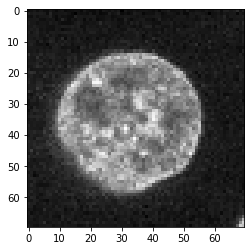

In [2]:
image = cells3d()[30,1,120:190,80:150]
imshow(image)

Weiterhin konstruieren wir ein künstliches PSF-Bild. Wir beginnen mit einem perfekten PSF-Bild, das in allen Pixeln schwarz (`0`) ist, außer in einem, typischerweise, aber nicht notwendigerweise, in der Mitte.

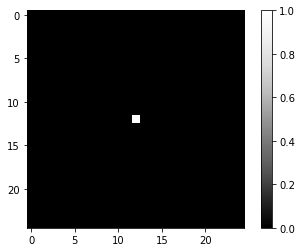

In [3]:
perfect_psf = np.zeros( (25,25) )
perfect_psf[12, 12] = 1

imshow(perfect_psf, colorbar=True)

Beachten Sie, dass in dem obigen Beispiel die Gesamtintensität im Bild 1 beträgt. Auch das im Folgenden gezeigte unscharfe Bild wird annähernd eine Gesamtintensität von 1 haben. Dies ist entscheidend für die spätere Entfaltung, da es ermöglicht, dass sich die Gesamtintensität in einem Bild (oder einer beliebigen abgebildeten biologischen Struktur) durch die Entfaltung nicht ändert.

Aus dieser perfekten PSF leiten wir ein realistischeres Beispiel-PSF ab, indem wir es mit einem Gauß'schen Weichzeichner unscharf machen.

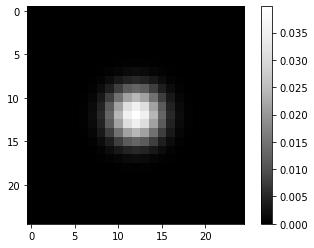

In [4]:
psf = gaussian(perfect_psf, sigma=2)

imshow(psf, colorbar=True)

## Faltung
Wie im Abschnitt über [Bildfilterung](image-filtering:convolution) eingeführt, ist die Faltung der Prozess der Kombination jedes Pixelwertes eines gegebenen Eingangsbildes mit benachbarten Pixeln, gewichtet entsprechend der PSF.

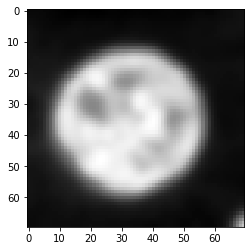

In [5]:
convolved = convolve(image, psf)

imshow(convolved)

## Entfaltung
Ein gängiger Algorithmus zur Wiederherstellung des Originalbildes aus dem gefalteten Bild ist die [Richardson-Lucy-Entfaltung](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution), die als [SimpleITK's RichardsonLucyDeconvolutionImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1RichardsonLucyDeconvolutionImageFilter.html) implementiert ist. Hier verwenden wir eine Komfortschicht, die Teil von [napari-simpleitk-image-processing] ist.

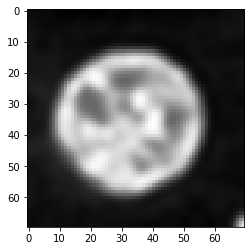

In [6]:
number_of_iterations = 10
deconvolved = richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

imshow(deconvolved)

Wie Sie sehen können, ist dieses entfaltete Bild nicht identisch mit dem oben gezeigten Originalbild. Entfaltung ist keine Zauberei. Es ist ein Bildverarbeitungsfilter, und alle Filter haben ihre Grenzen. Darüber hinaus hängt bei diesem Entfaltungsalgorithmus das Ergebnis von der Anzahl der Iterationen ab. Wir können empirisch eine gute Zahl für diesen Parameter finden, indem wir verschiedene Werte testen.

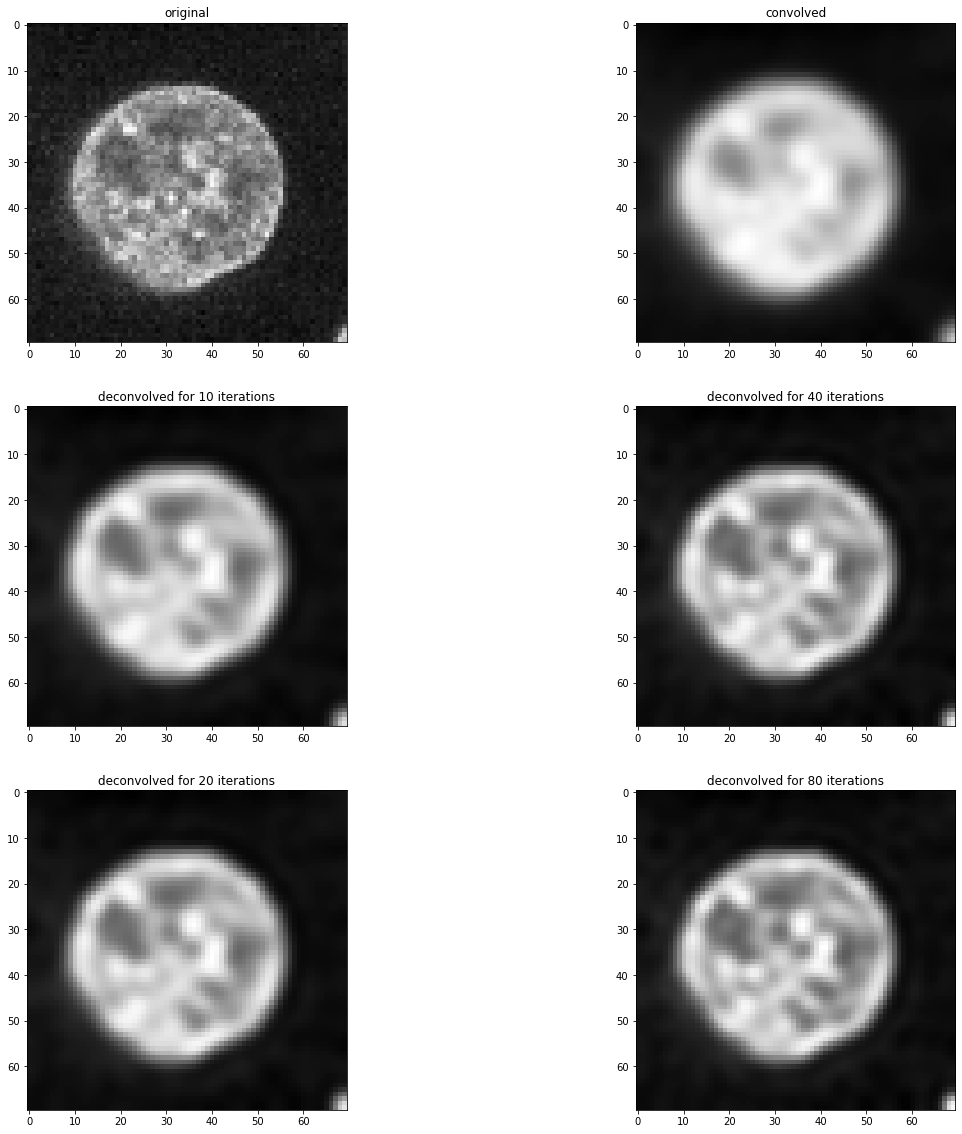

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

imshow(image, plot=axs[0, 0])
axs[0,0].set_title("original")

imshow(convolved, plot=axs[0, 1])
axs[0,1].set_title("gefaltet")

for i, number_of_iterations in enumerate([10, 20, 40, 80]):

    deconvolved = richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

    axis = axs[(i) % 2 + 1, int((i) / 2)]
    imshow(deconvolved, plot=axis)
    
    axis.set_title("entfaltet für " + str(number_of_iterations) + " Iterationen")

# Übung
Programmieren Sie eine for-Schleife, die das `convolved` Bild mit verschiedenen `number_of_iterations` entfaltet und den [mittleren quadratischen Fehler](https://de.wikipedia.org/wiki/Mittlerer_quadratischer_Fehler) zwischen dem Originalbild und dem entfalteten Bild bestimmt.
Tipp: Sie können [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) verwenden.